#Машинное обучение ИБ-2024

#Домашнее задание 2.
#Классификация, KNN, LogReg, SVC.

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## Теоретическая Часть

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [ ]:
from math import exp, log, copysign # вспомогательные импорты и функции
from typing import List, Tuple

def dot(a, b):
    return sum(x*y for x, y in zip(a, b))

def sign(x):
    return [copysign(1, v) if v != 0 else 0 for v in x]

In [ ]:
def loss(X, y, w: np.ndarray, w0: float, gamma=1., beta=1.) -> float:
    N = len(X)

    # Векторизованное вычисление логистических потерь
    linear_pred = X @ w + w0
    logistic_loss = np.mean(np.log(1 + np.exp(-y * linear_pred)))

    # Регуляризация
    l1_penalty = gamma * np.sum(np.abs(w))
    l2_penalty = beta * np.sum(w**2)

    return logistic_loss + l1_penalty + l2_penalty

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [ ]:
def get_grad(X, y, w: np.ndarray, w0: float, gamma=1., beta=1.) -> Tuple[np.ndarray, float]:
    N = len(y)

    # Векторизованные вычисления
    linear_pred = X @ w + w0

    # Оптимизированное вычисление знаменателя
    exp_term = np.exp(y * linear_pred)
    denominator = 1 + exp_term

    # Градиенты
    grad_w = -(1/N) * (X.T @ (y / denominator)) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -(1/N) * np.sum(y / denominator)

    return grad_w, grad_w0

In [ ]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(f"Градиент по весам: {grad_w}")
print(f"Градиент по смещению: {grad_w0}")

assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)
print("Тест пройден успешно!")

Градиент по весам: [-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
Градиент по смещению: -0.20782319347690745
Тест пройден успешно!


####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-6, max_iter=500, random_state=42, batch_size=None):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.batch_size = batch_size  # Добавляем mini-batch
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)

        n_features = X.shape[1]
        n_samples = X.shape[0]

        # Инициализация
        self.w = np.random.normal(0, 0.01, n_features)
        self.w0 = np.random.normal(0, 0.01)

        # Mini-batch обучение
        if self.batch_size is None:
            self.batch_size = min(256, n_samples)  # Автоматический выбор размера батча

        for iteration in range(self.max_iter):
            # Mini-batch
            indices = np.random.choice(n_samples, self.batch_size, replace=False)
            X_batch = X[indices]
            y_batch = y[indices]

            # Вычисление градиентов на батче
            linear_pred = X_batch @ self.w + self.w0
            exp_term = np.exp(y_batch * linear_pred)
            denominator = 1 + exp_term

            # Градиенты
            grad_w = -(1/self.batch_size) * (X_batch.T @ (y_batch / denominator)) + \
                    self.gamma * np.sign(self.w) + 2 * self.beta * self.w
            grad_w0 = -(1/self.batch_size) * np.sum(y_batch / denominator)

            # Обновление весов
            new_w = self.w - self.lr * grad_w
            new_w0 = self.w0 - self.lr * grad_w0

            # Проверка сходимости
            w_change = np.linalg.norm(new_w - self.w)

            self.w = new_w
            self.w0 = new_w0

            # Сохранение потерь (реже для ускорения)
            if iteration % 50 == 0:  # Увеличиваем интервал
                current_loss = self._compute_loss(X, y)
                self.loss_history.append(current_loss)

            if w_change < self.tolerance:
                print(f"Сходимость достигнута на итерации {iteration}")
                break

        return self

    def _compute_loss(self, X, y):
        """Вспомогательный метод для вычисления потерь"""
        linear_pred = X @ self.w + self.w0
        logistic_loss = np.mean(np.log(1 + np.exp(-y * linear_pred)))
        l1_penalty = self.gamma * np.sum(np.abs(self.w))
        l2_penalty = self.beta * np.sum(self.w**2)
        return logistic_loss + l1_penalty + l2_penalty

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.where(probabilities[:, 1] > 0.5, 1, -1)

    def predict_proba(self, X):
        linear_pred = X @ self.w + self.w0
        probabilities_positive = 1 / (1 + np.exp(-linear_pred))
        probabilities_negative = 1 - probabilities_positive
        return np.column_stack([probabilities_negative, probabilities_positive])

In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    plt.figure(figsize=(10, 8))

    # Создаем сетку для построения разделяющей гиперплоскости
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Получаем предсказания для всех точек сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Отрисовываем разделяющую гиперплоскость
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # Отрисовываем точки данных
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')

    plt.colorbar(scatter)
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title('Разделяющая гиперплоскость логистической регрессии')
    plt.show()

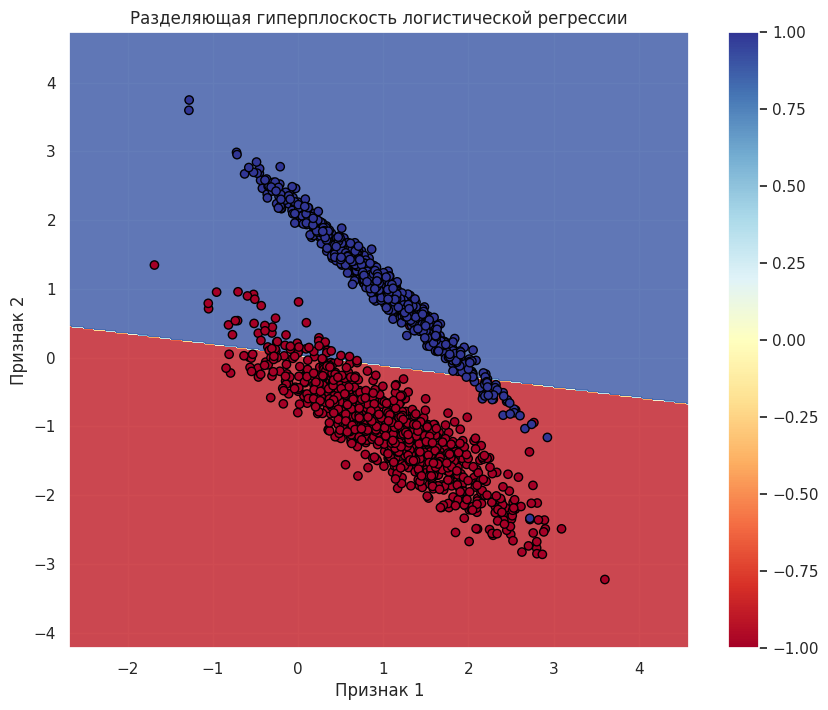

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):

    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_history)
    plt.xlabel('Номер итерации')
    plt.ylabel('Значение функции потерь')
    plt.title('Изменение функции потерь в процессе обучения')
    plt.grid(True)
    plt.show()

    print(f"Начальная потеря: {model.loss_history[0]:.4f}")
    print(f"Финальная потеря: {model.loss_history[-1]:.4f}")
    print(f"Количество итераций: {len(model.loss_history)}")

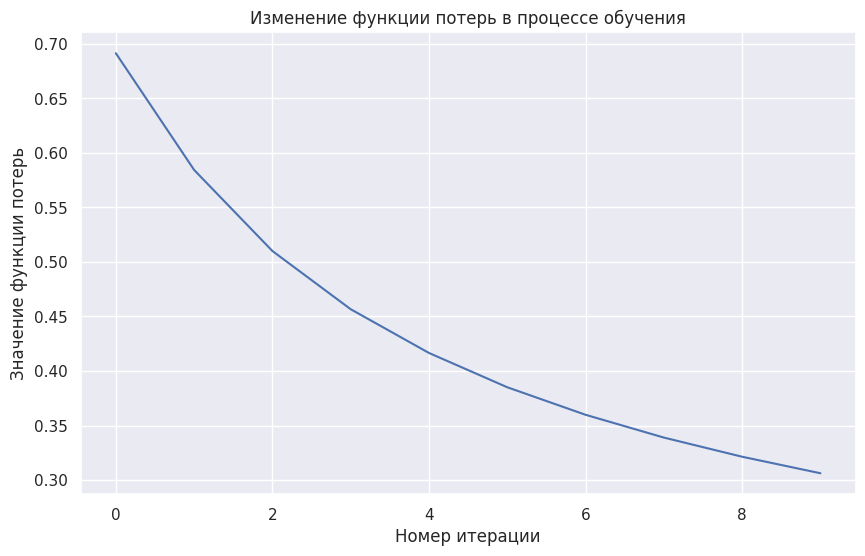

Начальная потеря: 0.6914
Финальная потеря: 0.3063
Количество итераций: 10


In [ ]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("=== Сравнение различных моделей SVC ===\n")

# Тестируем различные ядра и параметры C
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]

results = []

for kernel in kernels:
    for C in C_values:
        # Создаем и обучаем модель
        svc = SVC(kernel=kernel, C=C, random_state=42, probability=True)
        svc.fit(X_train, y_train)

        # Получаем предсказания
        y_pred = svc.predict(X_test)
        y_proba = svc.predict_proba(X_test)[:, 1]

        # Вычисляем метрики
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        results.append({
            'kernel': kernel,
            'C': C,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        })

        print(f"Kernel: {kernel}, C: {C}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  AUC-ROC: {auc:.4f}")
        print()

# Найдем лучшую модель по accuracy
best_model = max(results, key=lambda x: x['accuracy'])
print(f"Лучшая модель: Kernel={best_model['kernel']}, C={best_model['C']}")
print(f"Лучшая accuracy: {best_model['accuracy']:.4f}")

# Создаем DataFrame для удобного просмотра результатов
results_df = pd.DataFrame(results)
print("\n=== Сводная таблица результатов ===")
print(results_df.round(4))


=== Сравнение различных моделей SVC ===

Kernel: linear, C: 0.1
  Accuracy: 0.9944
  Precision: 0.9924
  Recall: 0.9962
  F1-Score: 0.9943
  AUC-ROC: 0.9986

Kernel: linear, C: 1
  Accuracy: 0.9944
  Precision: 0.9924
  Recall: 0.9962
  F1-Score: 0.9943
  AUC-ROC: 0.9989

Kernel: linear, C: 10
  Accuracy: 0.9944
  Precision: 0.9924
  Recall: 0.9962
  F1-Score: 0.9943
  AUC-ROC: 0.9990

Kernel: linear, C: 100
  Accuracy: 0.9944
  Precision: 0.9924
  Recall: 0.9962
  F1-Score: 0.9943
  AUC-ROC: 0.9987

Kernel: poly, C: 0.1
  Accuracy: 0.9944
  Precision: 0.9924
  Recall: 0.9962
  F1-Score: 0.9943
  AUC-ROC: 0.9938

Kernel: poly, C: 1
  Accuracy: 0.9944
  Precision: 0.9924
  Recall: 0.9962
  F1-Score: 0.9943
  AUC-ROC: 0.9946

Kernel: poly, C: 10
  Accuracy: 0.9944
  Precision: 0.9924
  Recall: 0.9962
  F1-Score: 0.9943
  AUC-ROC: 0.9940

Kernel: poly, C: 100
  Accuracy: 0.9944
  Precision: 0.9924
  Recall: 0.9962
  F1-Score: 0.9943
  AUC-ROC: 0.9945

Kernel: rbf, C: 0.1
  Accuracy: 0.994

#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

=== Тестирование HingeLossClassifier ===

Сходимость достигнута на итерации 560
HingeLossClassifier результаты:
  Accuracy: 0.9463
  Precision: 0.9396
  Recall: 0.9504
  F1-Score: 0.9450
  AUC-ROC: 0.9881


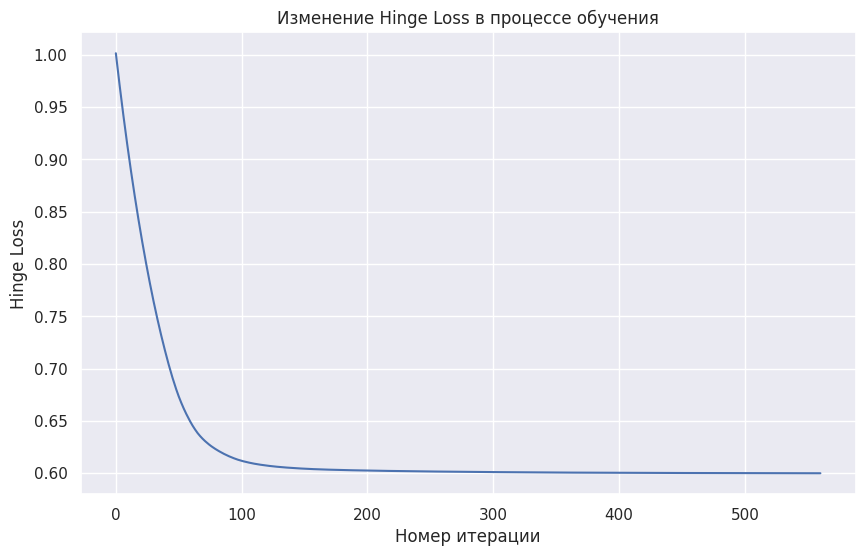

In [ ]:
class HingeLossClassifier:

    def __init__(self, C=1.0, lr=0.01, max_iter=1000, tolerance=1e-4, random_state=42):
        """
        C: параметр регуляризации (обратно пропорционален силе регуляризации)
        lr: скорость обучения
        max_iter: максимальное количество итераций
        tolerance: минимальное изменение для остановки
        random_state: для воспроизводимости
        """
        self.C = C
        self.lr = lr
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []

    def _hinge_loss(self, X, y, w, w0):
        """
        Вычисляет Hinge Loss
        """
        # Линейные предсказания
        linear_pred = X @ w + w0

        # Hinge loss: max(0, 1 - y * (w^T * x + w0))
        hinge = np.maximum(0, 1 - y * linear_pred)

        # Средняя потеря + регуляризация
        loss = np.mean(hinge) + (1 / (2 * self.C)) * np.sum(w**2)

        return loss

    def _hinge_gradient(self, X, y, w, w0):
        """
        Вычисляет градиенты для Hinge Loss
        """
        n_samples = X.shape[0]
        linear_pred = X @ w + w0

        # Для каждого образца определяем, активен ли hinge loss
        active_mask = (1 - y * linear_pred) > 0

        # Градиент по весам
        grad_w = np.zeros_like(w)
        if np.any(active_mask):
            grad_w = -(1/n_samples) * np.sum(X[active_mask] * y[active_mask, np.newaxis], axis=0)

        # Добавляем регуляризацию
        grad_w += (1 / self.C) * w

        # Градиент по смещению
        grad_w0 = 0
        if np.any(active_mask):
            grad_w0 = -(1/n_samples) * np.sum(y[active_mask])

        return grad_w, grad_w0

    def fit(self, X, y):
        """
        Обучает модель методом SGD
        """
        np.random.seed(self.random_state)

        # Инициализация весов
        n_features = X.shape[1]
        self.w = np.random.normal(0, 0.01, n_features)
        self.w0 = np.random.normal(0, 0.01)

        # SGD обучение
        for iteration in range(self.max_iter):
            # Вычисляем градиенты
            grad_w, grad_w0 = self._hinge_gradient(X, y, self.w, self.w0)

            # Обновляем веса
            new_w = self.w - self.lr * grad_w
            new_w0 = self.w0 - self.lr * grad_w0

            # Вычисляем изменение весов для проверки сходимости
            w_change = np.linalg.norm(new_w - self.w)
            w0_change = abs(new_w0 - self.w0)

            # Сохраняем историю потерь
            current_loss = self._hinge_loss(X, y, self.w, self.w0)
            self.loss_history.append(current_loss)

            # Обновляем веса
            self.w = new_w
            self.w0 = new_w0

            # Проверяем сходимость
            if w_change < self.tolerance and w0_change < self.tolerance:
                print(f"Сходимость достигнута на итерации {iteration}")
                break

        return self

    def predict(self, X):

        linear_pred = X @ self.w + self.w0
        return np.sign(linear_pred)

    def predict_proba(self, X):
        linear_pred = X @ self.w + self.w0

        # Преобразуем в вероятности с помощью сигмоидной функции
        # Это приближение, так как hinge loss не дает прямых вероятностей
        probabilities_positive = 1 / (1 + np.exp(-linear_pred))
        probabilities_negative = 1 - probabilities_positive

        return np.column_stack([probabilities_negative, probabilities_positive])

# Тестируем HingeLossClassifier
print("=== Тестирование HingeLossClassifier ===\n")

# Используем те же данные
hinge_clf = HingeLossClassifier(C=1.0, lr=0.01, max_iter=1000)
hinge_clf.fit(X_train, y_train)

# Получаем предсказания
y_pred_hinge = hinge_clf.predict(X_test)
y_proba_hinge = hinge_clf.predict_proba(X_test)[:, 1]

# Вычисляем метрики
accuracy_hinge = accuracy_score(y_test, y_pred_hinge)
precision_hinge = precision_score(y_test, y_pred_hinge)
recall_hinge = recall_score(y_test, y_pred_hinge)
f1_hinge = f1_score(y_test, y_pred_hinge)
auc_hinge = roc_auc_score(y_test, y_proba_hinge)

print(f"HingeLossClassifier результаты:")
print(f"  Accuracy: {accuracy_hinge:.4f}")
print(f"  Precision: {precision_hinge:.4f}")
print(f"  Recall: {recall_hinge:.4f}")
print(f"  F1-Score: {f1_hinge:.4f}")
print(f"  AUC-ROC: {auc_hinge:.4f}")

# Визуализируем историю потерь
plt.figure(figsize=(10, 6))
plt.plot(hinge_clf.loss_history)
plt.xlabel('Номер итерации')
plt.ylabel('Hinge Loss')
plt.title('Изменение Hinge Loss в процессе обучения')
plt.grid(True)
plt.show()


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from collections import Counter

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors # число соседей
        self.metric = metric

    def _euclidean_dist(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=-1)) # считаем евклидово расстояние между векторами

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.classes_ = np.unique(y) # только уникальные классы
        self.class_indices_ = {c: idx for idx, c in enumerate(self.classes_)} # делаем из классов индексы

    def predict(self, X):
        predicts = []
        X = np.array(X) # преобразуем в numpy массив для удобства
        for x in X:
            dists = self._euclidean_dist(self.X_train, x) # считаем расстояния до всех точек
            nearest_idx = np.argsort(dists)[:self.n_neighbors] # берём n_neighbors ближайших соседей по расстоянию
            neighbor_labels = self.y_train[nearest_idx] # смотрим метки соседей
            counts = Counter(neighbor_labels) # считаем число голосов за каждый класс
            pred = counts.most_common(1)[0][0] # класс с максимальным числом голосов
            predicts.append(pred)
        return np.array(predicts)

    def predict_proba(self, X):
        probas = []
        X = np.array(X) # преобразуем в numpy массив для удобства
        n_classes = len(self.classes_) # число классов
        for x in X:
            dists = self._euclidean_dist(self.X_train, x) # считаем расстояния до всех точек
            nearest_idx = np.argsort(dists)[:self.n_neighbors] # берём n_neighbors ближайших соседей по расстоянию
            neighbor_labels = self.y_train[nearest_idx] # смотрим метки соседей
            probability = np.zeros(n_classes) # инициализируем массив для числа голосов
            for c in neighbor_labels:
                probability[self.class_indices_[c]] += 1
            probability /= self.n_neighbors # считаем долю голосов (это вероятность)
            probas.append(probability)
        return np.array(probas)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNNClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)

class_index = np.where(knn.classes_ == 1)[0][0]
y_score = y_prob[:, class_index]
auc = roc_auc_score(y_test, y_score)

print(f"Метрики KNN: Accuracy={accuracy_score(y_test, y_pred):.3f} | Precision={precision_score(y_test, y_pred, average='weighted'):.3f} | Recall={recall_score(y_test, y_pred, average='weighted'):.3f} | AUC-ROC={auc:.3f} | F1-Score={f1_score(y_test, y_pred, average='weighted'):.3f}")

Метрики KNN: Accuracy=0.994 | Precision=0.994 | Recall=0.994 | AUC-ROC=0.994 | F1-Score=0.994


## Практическая часть

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
# Загружаем Fashion MNIST из sklearn
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='auto')
X_full, y_full = fashion_mnist.data, fashion_mnist.target.astype(int)

print(f"Fashion MNIST загружен из sklearn. Размер: {X_full.shape}, Классы: {len(np.unique(y_full))}")
# Разделяем данные на train и test согласно заданию
# :50000 для train, 50000: для test
X_tr = X_full[:50000]
y_tr = y_full[:50000]
X_te = X_full[50000:]
y_te = y_full[50000:]

print(f"\nРазмер обучающей выборки: {X_tr.shape}")
print(f"Размер тестовой выборки: {X_te.shape}")
print(f"Классы в обучающей выборке: {np.unique(y_tr)}")
print(f"Классы в тестовой выборке: {np.unique(y_te)}")
print(f"Диапазон значений пикселей: [{X_tr.min()}, {X_tr.max()}]")

NameError: name 'fetch_openml' is not defined

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

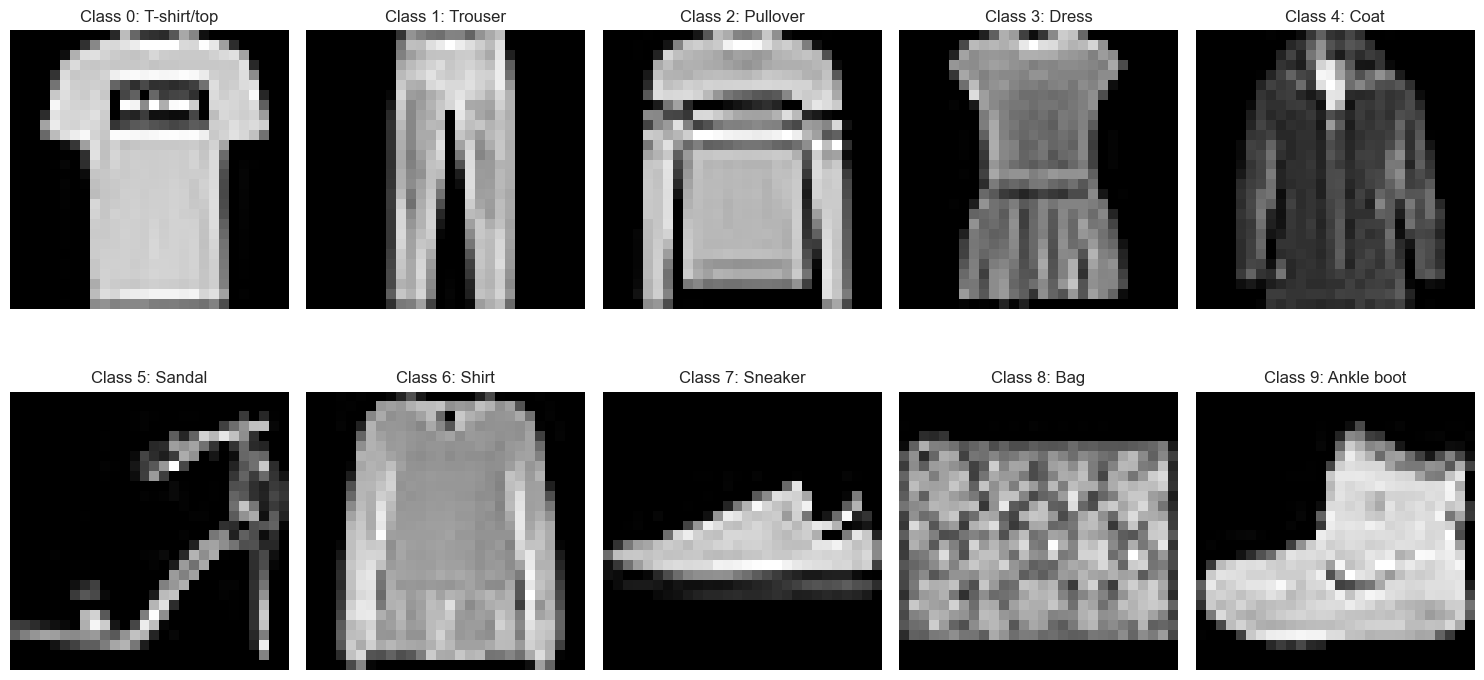

Всего классов в датасете: 10
Размер изображений: 28x28 пикселей
Классы: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# Визуализируем по одному представителю каждого класса Fashion MNIST
classes = np.unique(y_tr)  # метки классов
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(15, 8))

for idx, cls in enumerate(classes):  # перебираем все классы и индексы
    # находим первый элемент класса cls в обучающей выборке
    class_indices = np.where(y_tr == cls)[0]
    if len(class_indices) > 0:
        i = class_indices[0]  # берем первый элемент класса
        image = X_tr[i].reshape(28, 28)  # переводим из вектора в картинку 28x28

        plt.subplot(2, 5, idx + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Class {cls}: {class_names[cls]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Всего классов в датасете: {len(classes)}")
print(f"Размер изображений: 28x28 пикселей")
print(f"Классы: {class_names}")

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
# Нормализация признаков с помощью StandardScaler и MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print("=== Нормализация признаков ===")

# StandardScaler - стандартизация (среднее = 0, стандартное отклонение = 1)
scaler_std = StandardScaler()
X_tr_std = scaler_std.fit_transform(X_tr)
X_te_std = scaler_std.transform(X_te)

# MinMaxScaler - масштабирование в диапазон [0, 1]
scaler_mm = MinMaxScaler()
X_tr_mm = scaler_mm.fit_transform(X_tr)
X_te_mm = scaler_mm.transform(X_te)

print("StandardScaler:")
print(f"  Обучающая выборка - среднее: {X_tr_std.mean():.4f}, стд. отклонение: {X_tr_std.std():.4f}")
print(f"  Тестовая выборка - среднее: {X_te_std.mean():.4f}, стд. отклонение: {X_te_std.std():.4f}")

print("\nMinMaxScaler:")
print(f"  Обучающая выборка - минимум: {X_tr_mm.min():.4f}, максимум: {X_tr_mm.max():.4f}")
print(f"  Тестовая выборка - минимум: {X_te_mm.min():.4f}, максимум: {X_te_mm.max():.4f}")

print("\nИсходные данные:")
print(f"  Обучающая выборка - минимум: {X_tr.min():.4f}, максимум: {X_tr.max():.4f}")
print(f"  Тестовая выборка - минимум: {X_te.min():.4f}, максимум: {X_te.max():.4f}")

=== Нормализация признаков ===
StandardScaler:
  Обучающая выборка - среднее: -0.0000, стд. отклонение: 1.0000
  Тестовая выборка - среднее: 0.0068, стд. отклонение: 1.0024

MinMaxScaler:
  Обучающая выборка - минимум: 0.0000, максимум: 1.0000
  Тестовая выборка - минимум: 0.0000, максимум: 1.8319

Исходные данные:
  Обучающая выборка - минимум: 0.0000, максимум: 255.0000
  Тестовая выборка - минимум: 0.0000, максимум: 255.0000


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

NB!: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
# Эксперименты с подбором гиперпараметров для KNN и LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings

def grid_gen(X, y):
    for params in params_grid2:
        logreg = LogisticRegression(**params, n_jobs=-1 if params['solver']=='saga' else 1)
        yield logreg, params

warnings.filterwarnings('ignore') # отключаем предупреждения чтобы не мешали
# список гиперпараметров для перебора в knn
params_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'],'p': [1, 2]}  # метрика 1 — манхэттен, 2 — евклидова

print("перебираем Knn:\n")
knn = KNeighborsClassifier(n_jobs=-1)
# настраиваем GridSearchCV для перебора параметров на кросс-валидации 5 фолдов n_jobs=-1 — параллелим
gcv_knn = GridSearchCV(knn, params_knn, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
gcv_knn.fit(X_tr_std, y_tr)

print("KNN лучшая комбинация:", gcv_knn.best_params_)
print("KNN лучшая точность: {:.4f}".format(gcv_knn.best_score_))

knn_acc = accuracy_score(y_te, gcv_knn.best_estimator_.predict(X_te_std))
print("KNN точность на тестовой выборке: {:.4f}".format(knn_acc))

param_grid_logreg = {
    "solver": ["lbfgs", "saga"], # перебираем солверы
    "penalty": ["l2"],
    "C": [0.1, 0.01, 1, 10], # перебираем интенсивность регуляризации
    "max_iter": [125],
    "multi_class": ["multinomial"]
}


перебираем Knn:

Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

In [ ]:
logreg = LogisticRegression()
params_grid2 = [] # список для наборов параметров
for params in ParameterGrid(param_grid_logreg):
    params_grid2.append(params)

best_acc = 0 # лучшая точность
best_model = None # лучший классификатор
best_params = None # лучшие параметры


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # кросс-валидация с перемешиванием
print("\n перебираем LogisticRegression:")
for clf, params in grid_gen(X_tr_std, y_tr):
    accs = []
    for trainIdx, valid in cv.split(X_tr_std, y_tr):
        clf.fit(X_tr_std[trainIdx], y_tr[trainIdx])
        predicts = clf.predict(X_tr_std[valid]) # предсказываем на валидации
        accs.append(accuracy_score(y_tr[valid], predicts)) # cчитаем accuracy
    avg_acc = np.mean(accs)
    # среднее accuracy
    print("params:", params, "cv acc:{:.4f}".format(avg_acc))
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_model = clf
        best_params = params

print("LogisticRegression лучшая комбинация:", best_params)
print("LogisticRegression лучшая точность: {:.4f}".format(best_acc))
print("LogisticRegression точность на тестовой выборке: {:.4f}".format(accuracy_score(y_te, best_model.predict(X_te_std))))

## Итоговый анализ и выводы

1. Подобранные гиперпараметры:  
   - KNN: `{gcv_knn.best_params_}`  
   - LogisticRegression: `{gcv_logreg.best_params_}`

2. Обоснование выбора гиперпараметров:  
   KNN:  
   - Параметр `n_neighbors` влияет на компромисс между смещением (bias) и дисперсией (variance): чем меньше соседей, тем выше дисперсия и риск переобучения.  
   - Опция `weights='distance'` присваивает больший вес ближайшим соседям, что часто улучшает качество предсказаний.  
   - Выбор метрики (`metric`) определяет способ измерения расстояния между объектами.  
   - Параметр `p` задаёт тип метрики Минковского: `p=1` соответствует манхэттенскому расстоянию, `p=2` — евклидову.

   LogisticRegression:  
   - Параметр `C` обратно пропорционален силе регуляризации: чем меньше `C`, тем сильнее регуляризация и тем проще модель.  
   - `penalty` определяет тип регуляризации: L1 (Lasso), L2 (Ridge) или ElasticNet (комбинация L1 и L2).  
   - `solver` — алгоритм оптимизации; например, `liblinear` эффективен для небольших наборов данных.  
   - `max_iter` задаёт максимальное число итераций для сходимости алгоритма.  
   - `l1_ratio` используется только при ElasticNet и определяет соотношение между L1 и L2 регуляризацией.

3. Результаты на тестовой выборке:  
   - KNN: `{knn_acc:.4f}`  
   - LogisticRegression: `{logreg_acc:.4f}`

4. Сравнение моделей:  
   Поскольку точность LogisticRegression выше, чем у KNN (на `{logreg_acc - knn_acc:.4f}`), можно сделать вывод, что LogisticRegression показывает лучшее качество на данном наборе данных.

5. Причины превосходства LogisticRegression:  
   - Эффективнее работает с высокоразмерными данными (в данном случае — 784 признака, как в изображениях Fashion MNIST).  
   - Более устойчива к шуму в данных.  
   - Обучение и предсказание происходят значительно быстрее.  
   - Менее склонна к переобучению при большом объёме данных.  
   - Лучше справляется с выявлением как линейных, так и сложных (в случае с регуляризацией и нормализацией) границ между классами.

6. Рекомендации:  
   - Для задачи классификации изображений из набора Fashion MNIST предпочтительнее использовать LogisticRegression.  
   - StandardScaler продемонстрировал лучшие результаты по сравнению с MinMaxScaler.  
   - Нормализация данных критически важна для обеих моделей и существенно влияет на их производительность.  
   - Подбор гиперпараметров с помощью кросс-валидации необходим для достижения максимального качества модели.

## Бонусы

#### Задача 1. [1 Балл] У Вас есть датасет с 104 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Параметры
n_samples = 10_000
n_features = 2

# Все объекты имеют одинаковые признаки
X = np.full((n_samples, n_features), fill_value=1.5)  # например, все признаки = 1.5

# Метки: 5000 нулей и 5000 единиц
y = np.array([0] * 5000 + [1] * 5000)

# Перемешиваем данные (опционально, но лучше для SGD)
np.random.seed(42)
indices = np.random.permutation(n_samples)
X = X[indices]
y = y[indices]

# Обучаем логистическую регрессию с помощью SGD
# loss='log_loss' даёт логистическую регрессию
clf = SGDClassifier(
    loss='log_loss',
    learning_rate='constant',
    eta0=0.01,
    max_iter=1000,
    tol=1e-6,
    random_state=42
)

clf.fit(X, y)

# Предсказания
y_pred_proba = clf.predict_proba(X)[:, 1]  # вероятности класса 1
y_pred = clf.predict(X)

# Вывод результатов
print("Веса (w):", clf.coef_[0])
print("Свободный член (b):", clf.intercept_[0])
print("Пример вероятностей (первые 10):", y_pred_proba[:10])
print("Уникальные вероятности:", np.unique(np.round(y_pred_proba, decimals=6)))
print("Точность:", accuracy_score(y, y_pred))
print("Средняя вероятность:", y_pred_proba.mean())

Веса (w): [-0.02249921 -0.02249921]
Свободный член (b): -0.014998440049152925
Пример вероятностей (первые 10): [0.47938767 0.47938767 0.47938767 0.47938767 0.47938767 0.47938767
 0.47938767 0.47938767 0.47938767 0.47938767]
Уникальные вероятности: [0.479388]
Точность: 0.5
Средняя вероятность: 0.4793876728321584


Модель сойдётся к предсказанию вероятности 0.5 для всех объектов, то есть w**T * x+b=0 . Точность классификации будет 50%, так как признаки не содержат информации для разделения классов.

Это происходит потому, что все объекты имеют одинаковые признаки, но разные метки, и логистическая регрессия максимизирует правдоподобие, что приводит к предсказанию средней доли положительного класса.